## Setup

In [239]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

import pandas as pd

from IPython.display import clear_output

import scipy.stats as stats
from scipy.stats import norm, linregress
import sklearn
# from importlib import reload

### define project paths

In [240]:
## relative root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '3_relate_drawing_training_and_recog_prepost'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import utils 
reload(utils)
utils.data_dir = data_dir
utils.path_to_recog = os.path.join(data_dir, 'features/recog')
utils.path_to_draw = os.path.join(data_dir, 'features/drawing')
utils.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
utils.roi_list_recog = np.array(['V1', 'V2', 'LOC', 'fusiform','parahippo','IT','ento','PRC','hipp'])
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento', 'hipp']
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC']
roi_formatter = dict(zip(roi_list,roi_list_formatted))
roi_list_recog = utils.roi_list_recog

### relate individual differences in overall target selectivity (log odds of target vs. foil) to prepost differentiation

This plots the raw correlations between classifer evidence for target - foil, and prepost differentiation between trained objects

In [264]:
version = '4way'
target_selection = pd.read_csv(os.path.join(proj_dir,'csv/object_classifier_logodds_production.csv'))
target_selection['roi_formatted'] = target_selection['roi'].apply(lambda x: roi_formatter[x])
target_selection = target_selection.drop('roi',axis=1)
target_selection = target_selection.rename(columns={'roi_formatted':'roi'})

,target-foil,target-control,foil-control,sub,roi
0,0.166797,0.168756,0.001959,110171,V1
1,-0.376876,-0.358052,0.018825,110172,V1
2,0.002253,0.113622,0.111369,111171,V1
3,0.517825,0.279221,-0.238603,112171,V1
4,0.118490,-0.004151,-0.122641,112172,V1


In [257]:
## load in version of prepost that has probs 
prepost = pd.read_csv(os.path.join(results_dir,'prepost_recog_probs.csv'))
x = prepost[prepost['trained']==True].groupby(['roi_formatted','subj','phase'])['target_prob_raw'].mean().reset_index()
x['foil_prob_raw'] = prepost[prepost['trained']==True].groupby(['roi_formatted','subj','phase'])['foil_prob_raw'].mean().reset_index()['foil_prob_raw']
## split then splice together so that each row contains subject's own pre and post probs, then add raw prob difference column
x2 = x[x['phase']=='pre'].reset_index().join(x[x['phase']=='post'].reset_index(),rsuffix='_post', lsuffix='_pre')

######### raw probabilities ########
## raw prob prepost changes within target, and within foil
x2['target_rawprob_postpre'] = x2['target_prob_raw_post'] - x2['target_prob_raw_pre']
x2['foil_rawprob_postpre'] = x2['foil_prob_raw_post'] - x2['foil_prob_raw_pre']

## raw probs target vs. foil in each phase
x2['target_foil_rawprob_pre'] = x2['target_prob_raw_pre'] - x2['foil_prob_raw_pre']
x2['target_foil_rawprob_post'] = x2['target_prob_raw_post'] - x2['foil_prob_raw_post']

## raw probs prepost change in target vs. foil
x2['target_foil_rawprob_postpre'] =  x2['target_foil_rawprob_post'] - x2['target_foil_rawprob_pre']

######### log odds ########
## get log probs and get log odds column
x2['target_logprob_pre'] = np.log(x2['target_prob_raw_pre'])
x2['target_logprob_post'] = np.log(x2['target_prob_raw_post'])
x2['foil_logprob_pre'] = np.log(x2['foil_prob_raw_pre'])
x2['foil_logprob_post'] = np.log(x2['foil_prob_raw_post'])

## log odds target vs. foil in each phase
x2['target_foil_logodds_pre'] = x2['target_logprob_pre'] - x2['foil_logprob_pre']
x2['target_foil_logodds_post'] = x2['target_logprob_post'] - x2['foil_logprob_post']

## log odds for change within target, and within foil
x2['target_logodds_postpre'] = x2['target_logprob_post'] - x2['target_logprob_pre']
x2['foil_logodds_postpre'] = x2['foil_logprob_post'] - x2['foil_logprob_pre']

## log odds prepost change in target vs. foil
x2['target_foil_logodds_postpre'] = x2['target_logodds_postpre'] - x2['foil_logodds_postpre']


In [261]:
## define new dataframe which just has the goods
x3 = x2[['roi_formatted_pre','subj_pre','target_rawprob_postpre','target_logodds_postpre']]
x3.columns = ['roi','sub','logodds','rawdiff']


In [262]:
## join the prepost recognition and production phase dataframes
prepost = x3.sort_values(['roi','sub'])
target_selection = target_selection.sort_values(['roi','sub']).reset_index(drop=True)
joined = target_selection.join(prepost,rsuffix='_recog',lsuffix='_draw')

In [263]:
for name,group in joined.groupby('roi_recog'):
    print name, stats.pearsonr(group['target-foil'],group['logodds']), stats.pearsonr(group['target-foil'],group['rawdiff'])
    

ENT (0.19298230287998164, 0.29827347172390006) (0.18211014968970501, 0.3268342558003471)
FUS (0.05478487148466757, 0.7697406610558215) (0.046485291851212765, 0.803888950466356)
HC (0.10608975902321684, 0.5700240359583422) (0.09863104674003717, 0.5975844181341265)
IT (0.06148621752013727, 0.7424704263506338) (0.0762505754932469, 0.6834988423364465)
LOC (-0.026759588247701322, 0.8863740915241216) (-0.031438792356106235, 0.8666684426346212)
PHC (-0.03187130281079768, 0.8648507748479183) (-0.03938835791229674, 0.8333755264306414)
PRC (0.06760574196728662, 0.7178316094323245) (0.06949187809740506, 0.7102919334870452)
V1 (0.24082120765691128, 0.19187916052603923) (0.2156461249942979, 0.2439795347560409)
V2 (0.11520045666532545, 0.5371616064245588) (0.09688149057734938, 0.604131155430039)


In [ ]:
sns.set_context('talk')
g = sns.FacetGrid(joined, col='roi_recog',aspect=1,col_wrap=3)
g.map(plt.scatter,'target-foil','logodds')

ROI: V1  r = 0.21434  p = 0.24691 
ROI: V2  r = 0.21862  p = 0.23739 
ROI: LOC  r = -0.16357  p = 0.37927 
ROI: IT  r = 0.17884  p = 0.33575 
ROI: fusiform  r = 0.12527  p = 0.50192 
ROI: parahippo  r = -0.16319  p = 0.3804 
ROI: PRC  r = 0.00455  p = 0.98063 
ROI: ento  r = -0.0607  p = 0.74566 
ROI: hipp  r = -0.1946  p = 0.29416 


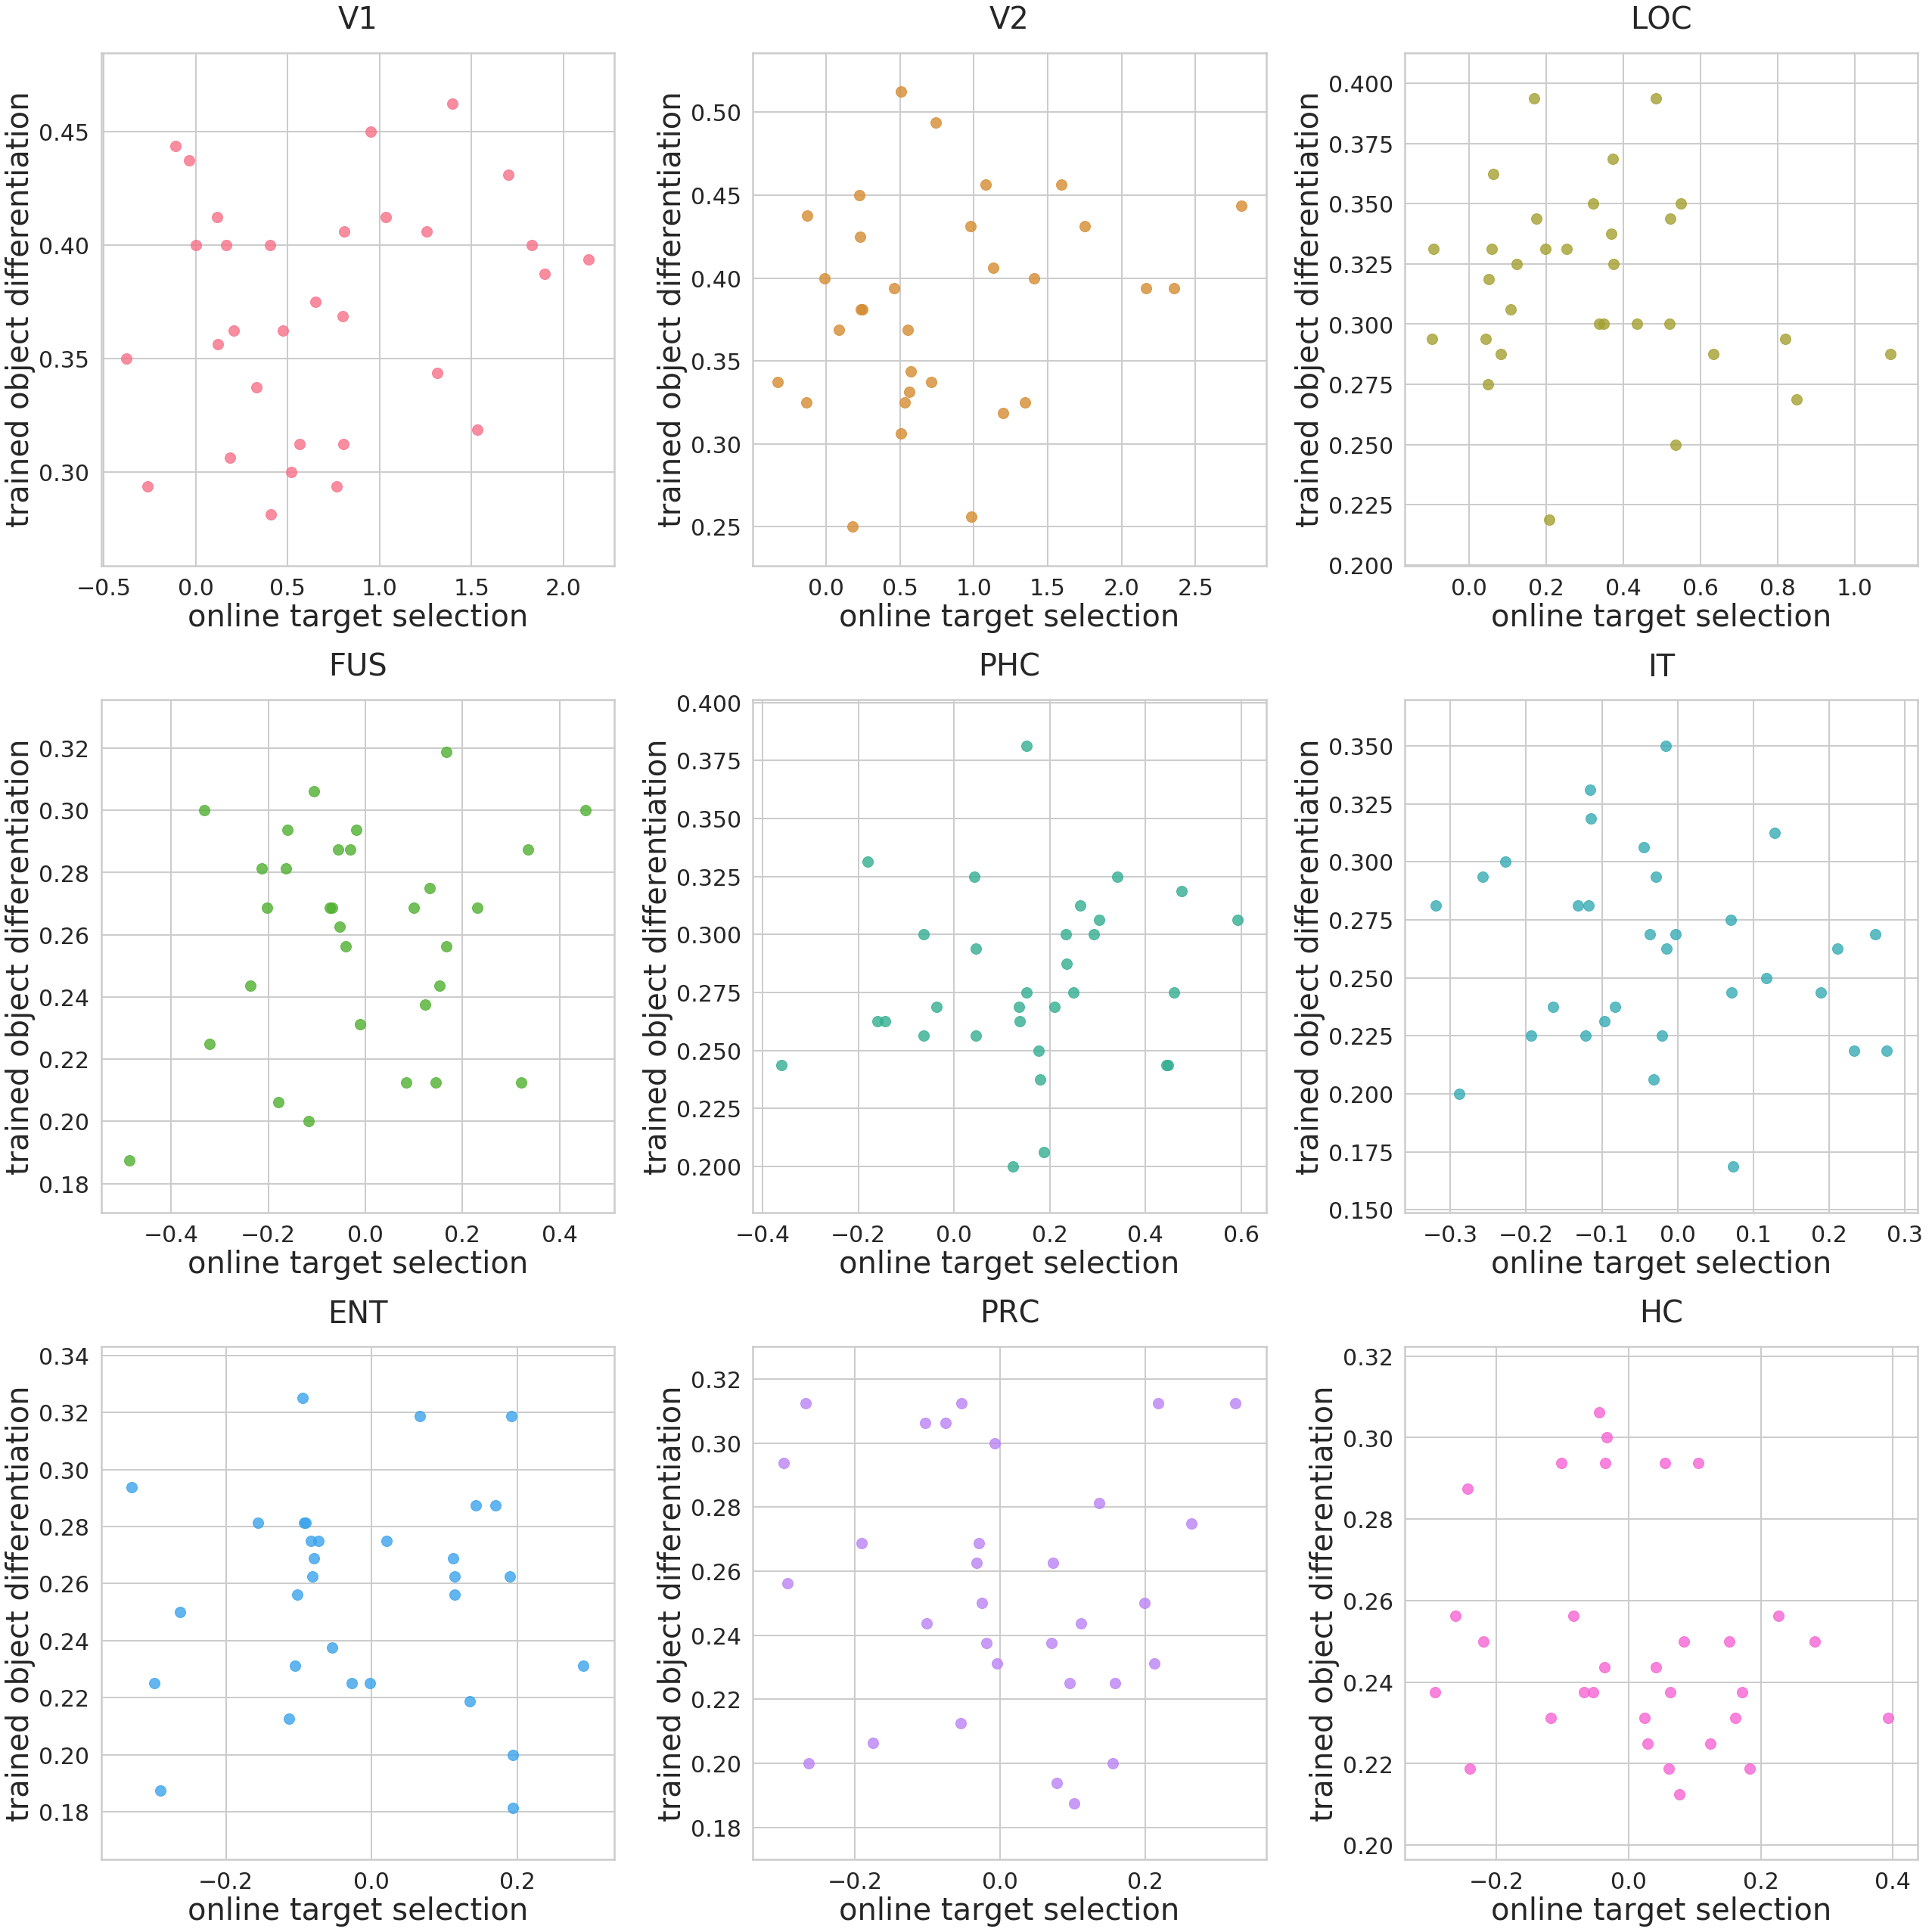

In [31]:
## make dataframe to relate drawing contrast to recognition differentiation
from matplotlib import rcParams
rcParams['axes.titlepad'] = 32 
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp']
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC']
roi_labels = list(prepost.roi.unique())*2
roi_dict = dict(zip(roi_list,prepost.roi.unique()))
sns.set_context('poster')
sns.set_style('whitegrid')
colors = sns.color_palette('husl',9)
draws, recogs = [], []
## plot 
fig = plt.figure(figsize=(36,36))
for ind,this_roi in enumerate(roi_list):
    draw = target_selection[target_selection['roi']==this_roi]['target-foil'].values
#     recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values
    recog = prepost[prepost['roi']==roi_dict[this_roi]]['acc'].values
    
    draws = np.array(draw) if len(draws)==0 else np.vstack((draws, np.array(draw)))
    recogs = np.array(recog) if len(recogs)==0 else np.vstack((recogs, np.array(recog)))

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    plt.subplot(3,3,ind+1)
    sns.regplot(x="draw",
                y ="recog",
                data=z,
                color=colors[ind],
                fit_reg=False,
                scatter_kws={'s':196,'alpha':0.8})
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    plt.title('{}'.format(roi_dict[this_roi]),fontsize=40)
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print('ROI: {}  r = {}  p = {} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
    plt.xlabel('online target selection',fontsize=40)  ## drawing: target vs. foil contrast
    plt.ylabel('trained object differentiation',fontsize=40) ## recog: post-pre differentiation
#     plt.xlim(-1.,3)
#     plt.ylim(-0.3,0.3)
    plt.tick_params(axis='both', which='major', labelsize=30)
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/'.format(nb_name)))
    plt.tight_layout()
#     plt.savefig(os.path.join(proj_dir,'plots/{}/draw_recog_scatter_allrois.pdf'.format(nb_name)))


#### try bar plot of correlation coefficients btw target_selection and prepost_diff by ROI

In [6]:
## merge target_selection and prepostdiff magnitudes by subject & roi
target_selection['sub'] = target_selection['sub'].apply(lambda x: str(x).zfill(7)) 
prepost['sub'] = prepost['sub'].apply(lambda x: str(x).zfill(7)) 
prepostdiff = prepost[prepost['condition']=='difference']
D = prepostdiff[['roi','prepost_diff','sub']].reset_index(drop=True)
D = D.assign(target_selection=target_selection['target-foil'])

In [7]:
def resample_subs(D,
                  groupby=['roi'],
                  random_state=0):
    
    Dboot = D.groupby(['roi']).apply(lambda x: x.sample(n=len(x), replace=True, random_state=random_state))
    cols = Dboot.columns
    Dboot = Dboot.xs(cols,axis=1,drop_level=True).reset_index(drop=True)
    return Dboot

def get_corr(x,y):
    return stats.pearsonr(x,y)[0]

def get_ci_bounds(x):
    lb = np.round(np.percentile(x,2.5),5)
    ub = np.round(np.percentile(x,97.5),5)
    return (lb,ub)

In [8]:
Corr_boot = []
nIter = 2000
for currIter in np.arange(nIter):
    print 'Running bootstrap iteration {} of {}'.format(currIter,nIter)
    clear_output(wait=True)
    Dboot = resample_subs(D,random_state=currIter)
    corr_boot = Dboot.groupby('roi').apply(lambda x: get_corr(x['prepost_diff'],x['target_selection']))    
    ## build up bootstrap dataframe
    if len(Corr_boot)==0:
        Corr_boot = corr_boot
    else:
        Corr_boot = pd.concat([Corr_boot,corr_boot],axis=1)  
Corr_boot = Corr_boot.transpose().reset_index(drop=True)        


Running bootstrap iteration 1999 of 2000


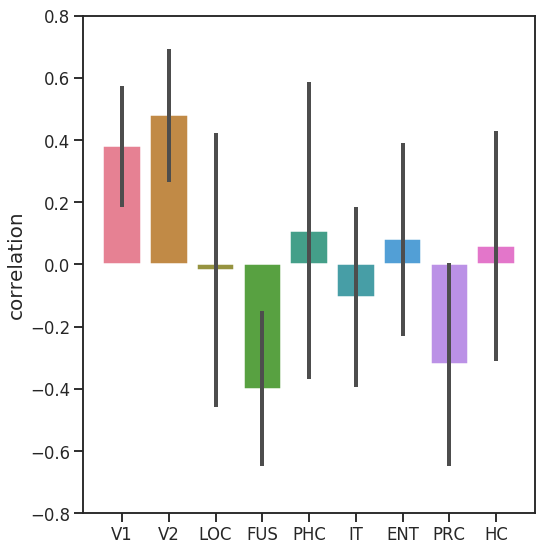

In [9]:
roi_list_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC'])
plt.figure(figsize=(8,8))
sns.set_context('talk')
sns.set_style('ticks')
sns.barplot(data=Corr_boot,
           order=roi_list_formatted,
           ci=None,
           palette='husl')
x = np.arange(len(roi_list_formatted))
sort_inds = np.argsort(roi_list_formatted)
reverse_sort_inds = np.argsort(sort_inds)
y = Corr_boot.mean(0).reset_index()[0][reverse_sort_inds].values # bar heights
yerr = Corr_boot.std(0).reset_index()[0][reverse_sort_inds].values # standard error
errbar_multiplier=2
plt.errorbar(x,
             y,
             yerr=yerr*errbar_multiplier,
             ecolor=(0.3,0.3,0.3),
             linestyle='',
             linewidth=4,
             capsize=0)
plt.xlabel('')
plt.ylim(-0.8,0.8)
plt.ylabel('correlation',fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(proj_dir,'plots/{}/draw_recog_bar_allrois.pdf'.format(nb_name)))

This plots correlations across phase and roi.

For example, does foil inhibition in one roi predict differentiation in another

In [10]:
# Do you want to (roughly) exclude non significant correlations in plot?
exclude_ns = True

In [11]:
# stats.pearsonr(draws[0],recogs[0])

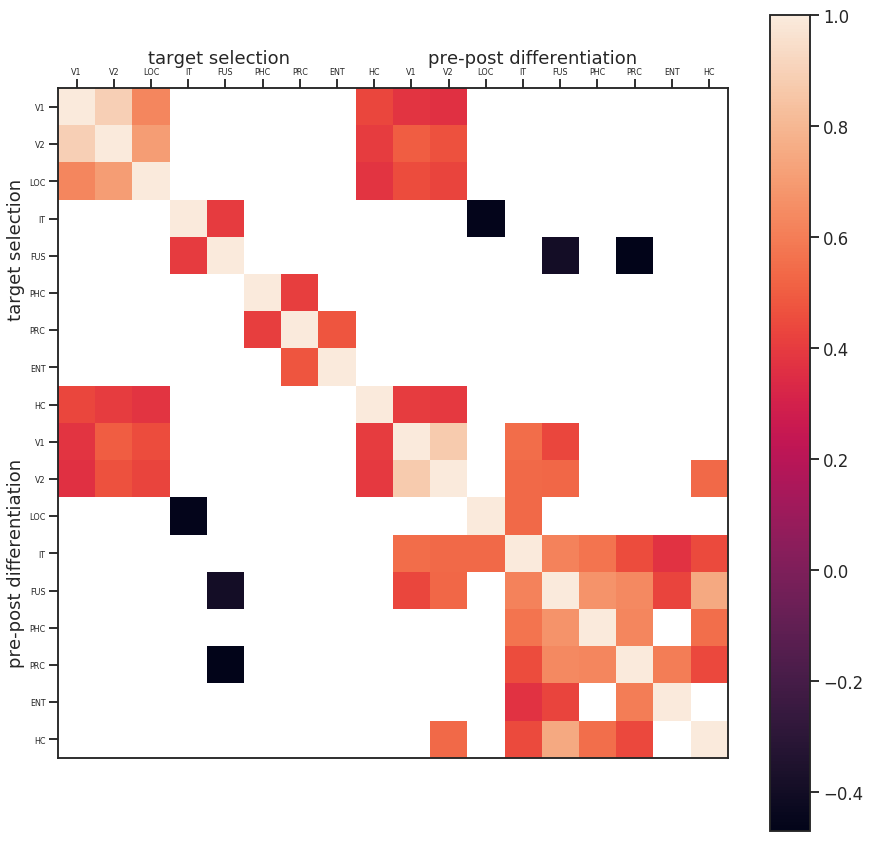

In [13]:
altogether = np.vstack((draws,recogs))
corrs = np.corrcoef(altogether)
derp = (corrs > -0.36) & (corrs < 0.36)
corrs2 = np.copy(corrs)
if exclude_ns:
    np.place(corrs2, derp, np.nan)
    fig, ax = plt.subplots(figsize=(15,15))
im = ax.matshow(corrs2)
ax.set_xticks(np.arange(len(roi_labels)))
ax.set_xticklabels(roi_labels, fontsize=8)
ax.set_yticks(np.arange(len(roi_labels)))
ax.set_yticklabels(roi_labels, fontsize=8)
ax.set_ylabel('pre-post differentiation                        target selection')
ax.set_xlabel('target selection                        pre-post differentiation')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.colorbar(im)
plt.show()

### Some observations:
* ROIs where we see positive relationship are: *V1*, *V2*. That is, individuals with GREATER target selectivity during drawing in these regions also show GREATER prepost differentiation.
* ROIs where we see negative relationship are: *fusiform*, *mOFC* (maybe PRC?) That is, individuals with LESS target selectivity during drawing in these regions also show GREATER prepost differentiation.

### When does the relationship between target selectivity and differentiation emerge in these ROIs?


In [1]:
# Set initial parameters
version = '4way'
logged = True
tag = 'logged' if logged else 'raw'
ALLDM = pd.read_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)))
ALLDM = h.cleanup_df(ALLDM)

roi_list = roi_list_recog
subs = np.unique(ALLDM.subj.values)
ivs = ['trial_num'] # ['run_num','trial_num','time_point']
takeDiffDifference = True ## compare trained object differentiation vs. control object differentiation?

NameError: name 'pd' is not defined

In [ ]:
specs = ('logged' if logged else 'raw')
for this_iv in ivs:
    for k,this_roi in enumerate(roi_list):
        # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
        # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
        scores = []
        for si,sub in enumerate(subs):
            print 'Analyzing | {} {} | {} {} '.format(si+1,sub,k+1,this_roi)
            clear_output(wait=True)                        
            inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
            t,f,c = h.get_prob_timecourse(this_iv,ALLDM[inds],version=version)

            if len(scores)==0:
                scores = t-f
            else:
                scores = np.vstack((scores,t-f))

        # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
        # in the same order as they are in the matrix.
        recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values

        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.
        if this_roi == 'Frontal':
            ## SEE HERE: lets decide what to do with classifier output == 0 in rare cases, ignore missing? 
            ## or add 1e-6 or smallest number in dataset so we can avoid having this catch here
            trial_corrs = [pd.DataFrame([scores[:,i], recog]).transpose().corr()[0][1] for i in range(np.shape(scores)[1])]
        else:
            trial_corrs = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]

        bootstrap = [h.corrbootstrapCI(scores[:,i], recog, 1000) for i in range(np.shape(scores)[1])]
        lower_bound, upper_bound = [b[1] for b in bootstrap], [b[2] for b in bootstrap]                 

        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(trial_corrs, 'ro', label='data')
        plt.axhline(y=0.0,linestyle='dashed')
        plt.ylim((-1,1))
        plt.ylabel('Correlation (t-c / prepost)')
        plt.xlabel(this_iv)
        plt.title('ROI: {}'.format(this_roi))
        plt.fill_between(np.arange(len(trial_corrs)), lower_bound, upper_bound, alpha=.2)

        if not os.path.exists(os.path.join(proj_dir,'plots/{}/'.format(nb_name))):
            os.makedirs(os.path.join(proj_dir,'plots/{}/'.format(nb_name)))
        plt.tight_layout()
        plt.savefig(os.path.join(proj_dir,'plots/{}/trial_corrs_{}_{}_{}.pdf'.format(nb_name, this_roi, *specs)))
        plt.close(fig)


### Create summary barplot of either mean correlation across subjects, or mean slope.

Choose any number of possible plots

NOTE: the full set of plots for 'mean' will create 32 plots and take ages.

In [ ]:
# read in data and set some initial parameters

ALLDM = pd.read_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,'logged' if logged else 'raw')))
prepost = pd.read_csv(os.path.join(str(results_dir),'neural_changes_by_surfroi_and_subject_longform.csv'))


takeDiffDifference = True

# Choose what measure to plot
plotting = 'mean' # ['mean', 'slope']

# choose which unit of time to iterate over
ivlist = ['run_num'] # ['run_num', 'trial_num', 'time_point']

# Choose whether to log or not
loglist = [True] # [True, False]

# Choose the critical measure for classifier output
measurelist = ['t-f'] # ['t','f','t-f','txf']

# ROI list
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp'])


units_dict = {'run_num': 4, 'trial_num': 20, 'time_point': 23}


In [ ]:
# Run through the plots, based on parameters above
for this_iv in ivlist:
    units = units_dict[this_iv]
    for logged in loglist:
        for clfmeasure in measurelist:
            print('logged: {}; clf: {}; iv: {}'.format(logged, clfmeasure, this_iv))            
            specs = ('logged' if logged else 'raw')
            subs = np.unique(ALLDM.subj.values)

            columns = []
            for this_roi in roi_list:
                _scores = np.array([h.get_prob_timecourse(this_iv,ALLDM[(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)]) for sub in subs])
                scores = [h.compute_clf_measure(_scores[i,0,:], _scores[i,1,:], clfmeasure) for i in range(_scores.shape[0])]
                objs = [str(np.unique(ALLDM[(ALLDM['subj']==sub)].label.values)) for sub in subs]                
                recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values                        
                columns.append([{'clf':scores[i], 'diff':recog[i], 'objs':objs[i]} for i in range(len(scores))])
            bardf = pd.DataFrame(columns).transpose()
            bardf.columns = roi_list

            if plotting == 'mean':

                # derive from bardf the df we want to plot and the error bars we want
                meandf = pd.DataFrame([h.scoreVSdiff(np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
                meandf.columns = roi_list
                error = [h.custom_bootstrapCI(np.array(bardf)[:,i], h.scoreVSdiff, 1000, roi_list[i])[1:3] for i in range(len(roi_list))]
                title = 'Subjectwise Relationship B/t Mean({}) & PrePost Diff'.format(clfmeasure)
                ylab = 'Average Correlation'
                outfig = 'mean_{}_{}_{}_{}.png'.format(this_iv, clfmeasure, *specs)

            else:

                # derive from bardf the df we want to plot and the error bars we want
                meandf = pd.DataFrame([h.slope_scoreVSdiff(np.array(bardf)[:,i], roi_list[i], units) for i in range(len(roi_list))]).transpose()
                meandf.columns = roi_list
                error = [h.custom_bootstrapCI(np.array(bardf)[:,i], h.slope_scoreVSdiff, 1000, roi_list[i], units)[1:3] for i in range(len(roi_list))]
                title = 'Slope over Timepoints of Subjectwise Relationship B/t {} & Prepost Diff'.format(clfmeasure)
                ylab = 'Average Slope'
                outfig = 'slope_{}_{}_{}_{}.png'.format(this_iv, clfmeasure, *specs)

            fig = plt.figure(figsize=(17,6))
            sns.barplot(data=meandf,palette='husl',ci=None)
            plt.xlabel('ROIs')
            plt.title(title) 
            plt.ylabel(ylab) 
            for i in range(len(roi_list)):
                plt.vlines(i, error[i][0], error[i][1])
            if not os.path.exists(os.path.join(proj_dir,'plots/{}/'.format(nb_name))):
                os.makedirs(os.path.join(proj_dir,'plots/{}/'.format(nb_name)))
            plt.tight_layout()
            plt.savefig(os.path.join(proj_dir,'plots/{}/'.format(nb_name), outfig))
            plt.close(fig)